In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from tqdm import tqdm
import time
warnings.filterwarnings('ignore')


# Ratio Metrics A/B test Design

Working with ratio metrics differs from cases with custom metrics. A ratio metric can be seen as an aggregation of two custom metrics. In this file, I will be examining the Average Order Value (sum of purchases / # of purchases). The specificity of ratio metrics is that, for comparing averages using a t-test, we cannot apply the traditional principle of 1 observation == 1 row because the data will be dependent, since one user tends to have higher Average Order Value than another. In this file, we will address this issue using a linearization approach, which will help transition from a ratio metric to a custom metric. We will calculate the design of our test and validate it with synthetic tests





### Experiment input:
We want to increase the average order value on our website. The average order value is a ratio metric (sum of purchases / # of purchases). To apply a t-test we are going to use Linearization method. 

Hypothesis: With the new recommendation algorithm in the cart based on ML, the average order value should increase. What are we changing? The recommendation algorithm in the cart. The target metric == average order value. All users who landed in the test group and placed an order on the website will participate in the experiment. Experiment will last for 2 weeks.

In [2]:
# Let's import our Fake pre-experimental data in order to estimate the test design
df = pd.read_csv('pre-experiment_data.csv')

# Filter data to get the closest pre-experimental period with the same number of days
df['order_date'] = pd.to_datetime(df['order_date'])
df = df[(df['order_date'] >= datetime(2023,11,6))
       & (df['order_date'] <= datetime(2023,11,19))]

df.head(5)

,order_id,revenue,order_date,user_id
0,0002dee6-1da3-4faf-83c0-dc36e3c50f66,106000,2023-11-17,22830274955380832781943083784441140139
1,00065e74-4778-45e1-97e2-66e231aa28d2,50000,2023-11-09,189448227854156374088676719303905172803
2,00072bdc-27bd-40f3-9a2f-357a87223a14,99000,2023-11-10,97671329982867732427142865366346279565
3,0007eedc-f5da-4826-ad60-2f5de9079828,92000,2023-11-06,1767834020355101491163632652999526981
4,00081c0d-3f38-4a57-85f6-071d843e0472,89000,2023-11-14,285723880525960879566269222887850603842


In [3]:
# To apply linearization we need to aggregate data for each user. 
# Numerator = x = sum of purchases, denominator = y = number of purchases

def get_grouped(df): # Function takes non-aggregated df with and outputs grouped df
    df = df.groupby('user_id')['revenue'].agg(['sum','count']).reset_index() \
        .rename(columns = {'user_id':'user_id', 'sum':'x', 'count':'y'})
    return df

df_grouped = get_grouped(df)
df_grouped.head(5)

,user_id,x,y
0,100001436828830373974506929290267578405,135000,1
1,100009995178437954493335519525704927432,150000,2
2,100016796050034219291016866675634396013,300000,2
3,100017488156497181925239570976442151637,98999,1
4,100019330275844793088214511561189720007,151999,1


### Linearization:

To move to linearization metric from ratio metric we need to:
1. Calculate kappa coefficient which is a ratio metric for CONTROL GROUP
2. Calculate linearization metric with: x - y * kappa

In [4]:
def get_kappa(x,y): # Function takes numerator and denominator of ratio metric then outputs kappa
    return x.sum() / y.sum()

def get_l_metric(df, kappa): # Funciton takes grouped df (1 user == 1 raw) and kappa then outputs df with l_metric
    df['l_metric'] = df['x'] - df['y'] * kappa
    return df

kappa = get_kappa(df_grouped['x'], df_grouped['y'])
df_grouped = get_l_metric(df_grouped, kappa)
print(f'kappa = {kappa}')
df_grouped.head(5)

kappa = 109616.1794138002


,user_id,x,y,l_metric
0,100001436828830373974506929290267578405,135000,1,25383.820586
1,100009995178437954493335519525704927432,150000,2,-69232.358828
2,100016796050034219291016866675634396013,300000,2,80767.641172
3,100017488156497181925239570976442151637,98999,1,-10617.179414
4,100019330275844793088214511561189720007,151999,1,42382.820586


### In order to determine sample_size for the experiment we need to determine alpha, beta, mde, and estimate standard deviation

In [5]:
alpha = 0.05
beta = 0.1
mde = 3000   # we determined mde of ratio metric as 3000
mde_l = mde * df_grouped['y'].mean() # for linearization metric we need to convert mde since we aproached new metric
std_l = df_grouped.l_metric.std()
print(f'''alpha = {alpha}, 
beta = {beta},
std_l = {std_l},
mde of ratio metric = {mde}, 
mde_l = {mde_l}''')

alpha = 0.05, 
beta = 0.1,
std_l = 94477.5183838617,
mde of ratio metric = 3000, 
mde_l = 3628.874609710847


In [6]:
# Now we can estimate sample_size:
def get_sample_size(mde, std, alpha, beta):
    numerator = 2 * (stats.norm.ppf(1-alpha/2) + stats.norm.ppf(1-beta))**2 * std**2
    denominator = mde**2
    return round(numerator / denominator)
sample_size = get_sample_size(mde_l, std_l, alpha, beta)
print(f'Sample_size > {sample_size}')

Sample_size > 14244


### We designed the experiment, but... 
Sample size seems to be too large, it is about 65% of all observations we get as a data. Maybe we should try to
increase the power/sensivity of our test to use less clients for the experiment. We have to reduce a varience. 
Let's use CUPED! It allows us to get rid of "exessive" variance explained by covariate. 

Let's calculate Cuped by taking our clients historical data (pre-pre-experimental period), then reduce variance

pre-pre-experimental period assign as k_df

In [7]:
k_df = pd.read_csv('pre-pre-experiment_data.csv') # Import pre-pre-experimental data
k_grouped = get_grouped(k_df) # aggregate df to use linearization

# We need to keep only those users that "participate" in our pre-experimental period
k_grouped = k_grouped[k_grouped['user_id'].isin(df_grouped.user_id.unique())]

# Let's calculate l_metric for pre-pre-experimental data
k_grouped = get_l_metric(k_grouped, kappa)
k_grouped.head(5)

,user_id,x,y,l_metric
1,100016796050034219291016866675634396013,101000,1,-8616.179414
2,100019330275844793088214511561189720007,120000,1,10383.820586
9,100073779418434809711127979498663747019,285000,2,65767.641172
11,100093885029525955483560361063391875313,76000,1,-33616.179414
12,100102794847195698781366525112522334095,284000,2,64767.641172


In [8]:
# Now we are going to merge our pre-experimental and pre-pre-experimental data
# m:: metric in pre-experimental period
# c:: covariate (same metric during pre-pre-experimental period)
df_grouped = df_grouped.rename(columns = {'l_metric':'m'}).merge(k_grouped[['user_id', 'l_metric']].rename(columns = {'l_metric':'c'}), how = 'left', on = 'user_id').fillna(0)

def get_cuped(df): # Function takes pd.DataFrames with m and c columns and return pd.DataFrame with cuped_metric
    """
    m:: metric during pre-experimental period
    c:: covariate
    
    return df
    """
    tetta = np.cov(df['m'],df['c'])[0,1] / np.var(df['c'])
    df['cuped_metric'] = df['m'] - tetta * (df['c'] - np.mean(df['c']))
    return df
                 
# Now let's determine Cuped metric 
df_grouped = get_cuped(df_grouped)
df_grouped[['user_id', 'cuped_metric']].head(5)

,user_id,cuped_metric
0,100001436828830373974506929290267578405,24105.851622
1,100009995178437954493335519525704927432,-70510.327792
2,100016796050034219291016866675634396013,84064.866660
3,100017488156497181925239570976442151637,-11895.148378
4,100019330275844793088214511561189720007,35591.039053


In [9]:
# Now let's estimate standard deviation for cuped metric to calculate sample size
std_cuped = df_grouped['cuped_metric'].std()
cuped_sample_size = get_sample_size(mde_l, std_cuped, alpha, beta)
print(f'Std for cuped metric = {std_cuped}')
print(f'Std without cuped = {std_l}')
print(f'Cuped sample size = {cuped_sample_size}')
print(f'Sample size without cuped = {sample_size}')

Std for cuped metric = 91856.66988529915
Std without cuped = 94477.5183838617
Cuped sample size = 13465
Sample size without cuped = 14244


We reduced our variance by 5,4% and our sample size decreased by 5,4% as well. Not so much difference. 
Maybe our metric and covarate are not correlated enough to reduce sample size?

In [10]:
pearson_corr = np.corrcoef(df_grouped['m'],df_grouped['c'])[0][1]
print(f'Our metric and covariate have correlation coefficient {round(pearson_corr,2)}')

Our metric and covariate have correlation coefficient 0.23


We were right, our metric and covariate have a relatively low correlation coefficient. 
Maybe next time we will try another period (4 weeks or 5 weeks) for estimation of covariate

# A/A and A/B tests to check our design
To make sure our experiment design controls first type error and second type error we can try it on historical data. Simulate our test many times.

100%|███████████████████████████████████████| 5000/5000 [06:00<00:00, 13.85it/s]


First Type Error = 0.0502


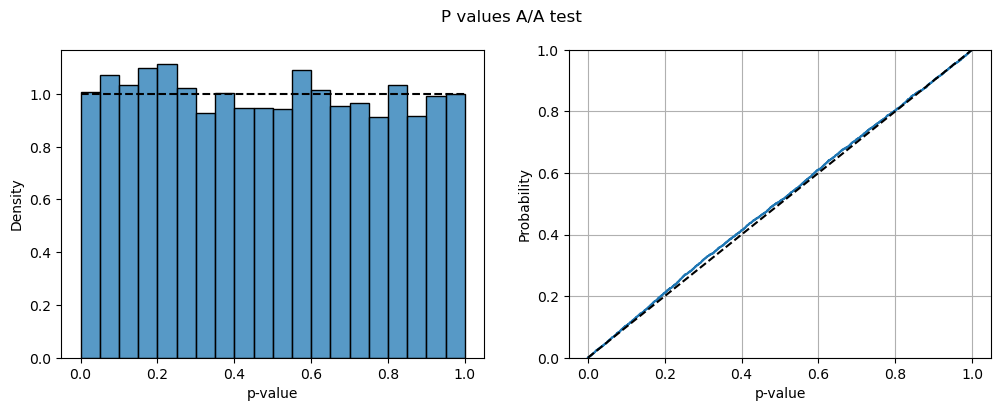

In [19]:
# A/A test of ratio metric using linearization + cuped
user_ids = df.user_id.unique().tolist()
pvalues_aa = []

for i in tqdm(range(5000)):
    # Let's assign pre-experimental period as df_1 and pre-pre-experimental period as df_0 
    df_1 = get_grouped(df)
    np.random.shuffle(user_ids)
    a1, a2 = user_ids[:cuped_sample_size], user_ids[len(user_ids) - cuped_sample_size:]
    a1, a2 = df_1[df_1['user_id'].isin(a1)].assign(group = 0), df_1[df_1['user_id'].isin(a2)].assign(group = 1)
    
    kappa = get_kappa(a1['x'], a1['y'])
    df_1 = get_l_metric(pd.concat([a1, a2]), kappa)
    df_0 = get_grouped(k_df) # pre-pre-experimental period
    df_0 = df_0.merge(df_1[['user_id', 'group']], how = 'right', on = 'user_id').fillna(0)
    df_0 = get_l_metric(df_0, kappa)
    df_ = get_cuped(df_1.rename(columns = {'l_metric':'m'}) \
                           .merge(df_0.rename(columns = {'l_metric':'c'})[['user_id', 'c']], on = 'user_id'))
    
    pvalue = stats.ttest_ind(df_.query('group == 1') \
                             .cuped_metric, df_.query('group == 0').cuped_metric, alternative = 'two-sided').pvalue
    pvalues_aa.append(pvalue)
    
def plot_pvalue_ecdf(pvalues, title=None): # Function creates P-value empirical distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if title:
        plt.suptitle(title)

    sns.histplot(pvalues, ax=ax1, bins=20, stat='density')
    ax1.plot([0,1],[1,1], 'k--')
    ax1.set(xlabel='p-value', ylabel='Density')

    sns.ecdfplot(pvalues, ax=ax2)
    ax2.plot([0,1],[0,1], 'k--')
    ax2.set(xlabel='p-value', ylabel='Probability')
    ax2.grid()
    
plot_pvalue_ecdf(pvalues_aa, title = 'P values A/A test')
print(f'First Type Error = {(np.array(pvalues_aa) < alpha).mean()}')

100%|███████████████████████████████████████| 5000/5000 [11:35<00:00,  7.19it/s]


Power = 0.8996


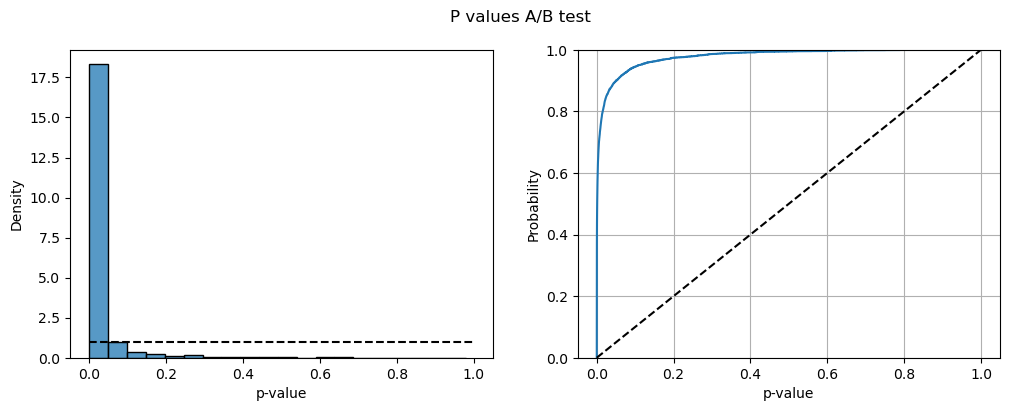

In [22]:
# A/B test of ratio metric using linearization + cuped
pvalues_ab = []

for i in tqdm(range(5000)):
    # Let's assign pre-experimental period as df_1 and pre-pre-experimental period as df_0 
    df_1 = get_grouped(df)
    np.random.shuffle(user_ids)
    a, b = user_ids[:cuped_sample_size], user_ids[len(user_ids) - cuped_sample_size:]
    a, b = df_1[df_1['user_id'].isin(a)].assign(group = 0), df_1[df_1['user_id'].isin(b)].assign(group = 1)
    
    kappa = get_kappa(a['x'], a['y'])
    df_1 = get_l_metric(pd.concat([a, b]), kappa)
    df_1['l_metric'] = df_1.apply(lambda row: row['l_metric'] if row['group'] == 0 else row['l_metric'] + mde_l, axis=1)
    df_0 = get_grouped(k_df) # pre-pre-experimental period
    df_0 = df_0.merge(df_1[['user_id', 'group']], how = 'right', on = 'user_id').fillna(0)
    df_0 = get_l_metric(df_0, kappa)
    df_ = get_cuped(df_1.rename(columns = {'l_metric':'m'}) \
                           .merge(df_0.rename(columns = {'l_metric':'c'})[['user_id', 'c']], on = 'user_id'))
    
    pvalue = stats.ttest_ind(df_.query('group == 1').cuped_metric, df_.query('group == 0') \
                             .cuped_metric, alternative = 'two-sided').pvalue
    pvalues_ab.append(pvalue)

plot_pvalue_ecdf(pvalues_ab, title = 'P values A/B test')
print(f'Power = {(np.array(pvalues_ab) < alpha).mean()}')

# Both First Type Error Probabilty and Power (1-beta) are controlled
This means the test design is correct and we can use the parameters below to conduct the experiment:

In [23]:
print(f'Metric = Average Order Value (sum of purchases / # of purchases)')
print(f'Sample size = {cuped_sample_size}')
print(f'Duration = 2 weeks')
print(f'Alpha = {alpha}, Beta = {beta}')
print(f'Mde of ratio metric = {mde}')

Metric = Average Order Value (sum of purchases / # of purchases)
Sample size = 13465
Duration = 2 weeks
Alpha = 0.05, Beta = 0.1
Mde of ratio metric = 3000
